# Models Predictions: Peaceful Protest

In [2]:
# Data Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Word imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Modeling Imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
senti_quote = pd.read_csv('../Data/integrated_protest_gb.csv')

In [4]:
senti_quote.head()

,id,date,month,year,city,state,time_precision,event_type,actor1,assoc_actor_1,...,Grenade,Looting/property destruction,Mob violence,Other,Peaceful protest,Protest with intervention,Remote explosive/landmine/IED,Sexual violence,Suicide bomb,Violent demonstration
0,2020-01-01_cleveland_oh,2020-01-01,1,2020,cleveland,oh,1,Protests,Protesters (United States),Health Workers (United States),...,0,0,0,0,1,0,0,0,0,0
1,2020-01-01_rochester_ny,2020-01-01,1,2020,rochester,ny,1,Protests,Protesters (United States),NaN,...,0,0,0,0,1,0,0,0,0,0
2,2020-01-01_oakland_ca,2020-01-01,1,2020,oakland,ca,1,Protests,Protesters (United States),BLM: Black Lives Matter,...,0,0,0,0,1,0,0,0,0,0
3,2020-01-01_phoenix_az,2020-01-01,1,2020,phoenix,az,1,Protests,Protesters (United States),Government of the United States (2017-2021),...,0,0,0,0,1,0,0,0,0,0
4,2020-01-01_oklahoma_city_ok,2020-01-01,1,2020,oklahoma_city,ok,1,Protests,Protesters (United States),NaN,...,0,0,0,0,1,0,0,0,0,0


### Assign Target and Feature

In [5]:
X = senti_quote['notes']
y= senti_quote['Peaceful protest']

### Baseline Accuracy

In [6]:
y.value_counts(normalize=True) # Reference peaceful protest

1    0.878099
0    0.121901
Name: Peaceful protest, dtype: float64

### Address the Imbalanced data

In [7]:
# Source: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

# Split the target variable value counts
val_1, val_0 = senti_quote['Peaceful protest'].value_counts()

# Separate values by assigning them
peace_0 = senti_quote[senti_quote['Peaceful protest'] == 0]
peace_1 = senti_quote[senti_quote['Peaceful protest'] == 1]
# print the shape of the target variable
print('Protest that are...')
print('')
print('Not peaceful:', peace_0.shape)
print('Peaceful:', peace_1.shape)

Protest that are...

Not peaceful: (3368, 83)
Peaceful: (24261, 83)


In [8]:
peace_under = peace_1.sample(n=val_0, random_state=42) 
# [the value with most counts].sample()
# n = [the value you want to match inorder to under sample]
# peace_under lists the rows as a df and observations won't exceed the count of the lowest value in the target variable

New totals of peaceful and non-peaceful protest: 
1    3368
0    3368
Name: Peaceful protest, dtype: int64


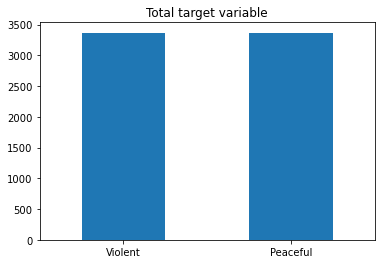

In [9]:
y_under = pd.concat([peace_under, peace_0], axis=0) # concat the peace_under to the values with the least counts in the target column

print("New totals of peaceful and non-peaceful protest: ")
print(y_under['Peaceful protest'].value_counts())# plot the count after under-sampeling

under = y_under['Peaceful protest'].value_counts().plot(kind='bar', title='Total target variable')
under.set_xticklabels(['Violent','Peaceful'])
plt.xticks(rotation=360);

### Re-assign Target and Feature to the balanced dataset

In [10]:
X = y_under['notes']
y= y_under['Peaceful protest']

### Split the balanced data

In [11]:
# Split the data into the training and testing sets. 
# Stratify to target so that the test and train target values remain evenly proportioned.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [12]:
# Apply additional stopwords
stopword = stopwords.words('english')
stop_word2 = ['size','2020','people','june','group']
stopword.extend(stop_word2) # extend the addtional stopwords to "stopword"

# Utilized Pipeline to instantiate multiple transformers for model.

------------
# Model 1 CountVectorizer & Multinomial Naives Bayes

In [13]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB()) # used Multinomial Naive Bayes since my X values consist of positive intergers
])
pipe_params = {
    'cv__stop_words': [stopword],
    "cv__max_features": [2000, 3000],
    'cv__min_df' : [1,2],
    'cv__max_df' : [.9,.95],
    'cv__ngram_range': [(1,1),(1,2)]

}

In [14]:
# Instantiate GridSearchCV.
grid = GridSearchCV(pipe, # optimize pipline
                  pipe_params, # search pipline params
                  cv=5, # 5-fold cross-validation for optimum value
                   verbose=0) 
grid.fit(X_train,y_train) # fit our training data

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cv__max_df': [0.9, 0.95],
                         'cv__max_features': [2000, 3000], 'cv__min_df': [1, 2],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]]})

In [15]:
# Evaluate which params gave us our best score
grid.best_params_

{'cv__max_df': 0.9,
 'cv__max_features': 3000,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
 

In [16]:
grid.best_score_ # evalulate best score

0.9376486372672875

In [17]:
print(f'Training score: {grid.score(X_train,y_train)}')
print(f'Testing score: {grid.score(X_test,y_test)}')

Training score: 0.9517022961203484
Testing score: 0.9376484560570071


<Figure size 1440x1440 with 0 Axes>

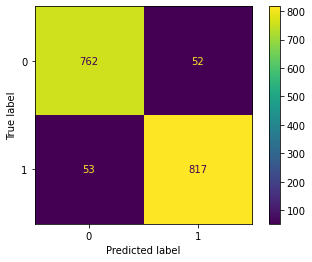

In [18]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(grid, X_test, y_test);# pass in grid and X and y test data to form confusion matrix values

## True positive: 762

## False positive: 52

## True negative: 817

## False negative: 53

In [19]:
preds = grid.predict(X_test) # use grid to predict testing data
print(classification_report(y_test, preds)) # Calculate the specificity

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       814
           1       0.94      0.94      0.94       870

    accuracy                           0.94      1684
   macro avg       0.94      0.94      0.94      1684
weighted avg       0.94      0.94      0.94      1684



## Classification Inference:

- Recall: Out of all positives, 94% of protest was predicted accurately to having a peaceful outcome.
- Precision: Out of all the positives, which were predicted to be correct, 94% were peaceful protest and 93% were not peaceful.

------------
# Model 2 CountVectorizer & Logistic Regression

In [20]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('logr', LogisticRegression(solver='liblinear'))
])
pipe_params = {
    'cv__stop_words': [stopword],
    "cv__max_features": [2000, 3000],
    'cv__min_df' : [1,2],
    'cv__max_df' : [.9,.95],
    'cv__ngram_range': [(1,1),(1,2)]

}

In [21]:
# Instantiate GridSearchCV.
grid = GridSearchCV(pipe, # optimize pipline
                  pipe_params, # search pipline params
                  cv=5) # 5-fold cross-validation for optimum value
grid.fit(X_train,y_train) # fit our training data

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('logr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'cv__max_df': [0.9, 0.95],
                         'cv__max_features': [2000, 3000], 'cv__min_df': [1, 2],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', 

In [22]:
# Evaluate which params gave us our best score
grid.best_params_

{'cv__max_df': 0.9,
 'cv__max_features': 3000,
 'cv__min_df': 2,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
 

In [23]:
grid.best_score_ # evalulate best score

0.9661523244312562

In [24]:
print(f'Training score: {grid.score(X_train,y_train)}')
print(f'Testing score: {grid.score(X_test,y_test)}')

Training score: 0.9990102929532858
Testing score: 0.9673396674584323


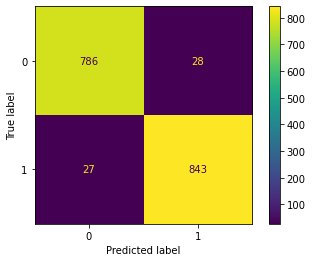

In [25]:
plot_confusion_matrix(grid, X_test, y_test)# pass in grid and X and y test data to form confusion matrix values

In [26]:
preds = grid.predict(X_test) # use grid to predict testing data
print(classification_report(y_test, preds)) # Calculate the specificity

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       814
           1       0.97      0.97      0.97       870

    accuracy                           0.97      1684
   macro avg       0.97      0.97      0.97      1684
weighted avg       0.97      0.97      0.97      1684



## Classification Inference:

- Recall: Out of all positives, 97% of protest was predicted accurately to having a peaceful outcome.
- Precision: Out of all the positives, which were predicted to be correct, 97% were peaceful protest and 97% were not peaceful.

_______________
# Model 3 TF-ID Vectorizer & Multinomial Naives Bayes

In [27]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('mnb', MultinomialNB()) # used Multinomial Naive Bayes since my X values consist of positive intergers
])
pipe_params = {
    'tf__stop_words': [stopword],
    "tf__max_features": [2000, 3000],
    'tf__min_df' : [1,2],
    'tf__max_df' : [.9,.95],
    'tf__ngram_range': [(1,1),(1,2)]

}

In [28]:
# Instantiate GridSearchCV.
grid = GridSearchCV(pipe, # optimize pipline
                  pipe_params, # search pipline params
                  cv=5) # 5-fold cross-validation for optimum value
grid.fit(X_train,y_train) # fit our training data

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tf__max_df': [0.9, 0.95],
                         'tf__max_features': [2000, 3000], 'tf__min_df': [1, 2],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]]})

In [29]:
# Evaluate which params gave us our best score
grid.best_params_

{'tf__max_df': 0.9,
 'tf__max_features': 2000,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
 

In [30]:
grid.best_score_ # evalulate best score

0.932305236458364

In [31]:
print(f'Training score: {grid.score(X_train,y_train)}')
print(f'Testing score: {grid.score(X_test,y_test)}')

Training score: 0.9439825811559779
Testing score: 0.9400237529691211


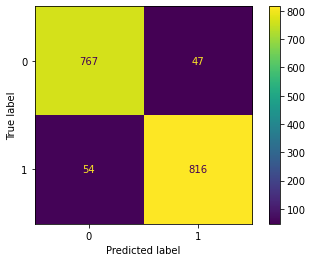

In [32]:
plot_confusion_matrix(grid, X_test, y_test)# pass in grid and X and y test data to form confusion matrix values

In [33]:
preds = grid.predict(X_test) # use grid to predict testing data
print(classification_report(y_test, preds)) # Calculate the specificity

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       814
           1       0.95      0.94      0.94       870

    accuracy                           0.94      1684
   macro avg       0.94      0.94      0.94      1684
weighted avg       0.94      0.94      0.94      1684



## Classification Inference:

- Recall: Out of all positives, 94% of protest was predicted accurately to having a peaceful outcome.
- Precision: Out of all the positives, which were predicted to be correct, 95% were peaceful protest and 93% were not peaceful.

_______________
# Model 4 TF-ID Vectorizer & Logistic Regressin

In [34]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('logr', LogisticRegression(solver='liblinear'))
])

pipe_params = {
    'tf__stop_words': [stopword],
    "tf__max_features": [2000, 3000],
    'tf__min_df' : [1,2],
    'tf__max_df' : [.9,.95],
    'tf__ngram_range': [(1,1),(1,2)]

}

In [35]:
# Instantiate GridSearchCV.
grid = GridSearchCV(pipe, # optimize pipline
                  pipe_params, # search pipline params
                  cv=5) # 5-fold cross-validation for optimum value
grid.fit(X_train,y_train) # fit our training data

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'tf__max_df': [0.9, 0.95],
                         'tf__max_features': [2000, 3000], 'tf__min_df': [1, 2],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', 

In [36]:
# Evaluate which params gave us our best score
grid.best_params_

{'tf__max_df': 0.9,
 'tf__max_features': 2000,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
 

In [37]:
grid.best_score_ # evalulate best score

0.95427701227096

In [38]:
print(f'Training score: {grid.score(X_train,y_train)}')
print(f'Testing score: {grid.score(X_test,y_test)}')

Training score: 0.9732779097387173
Testing score: 0.9655581947743468


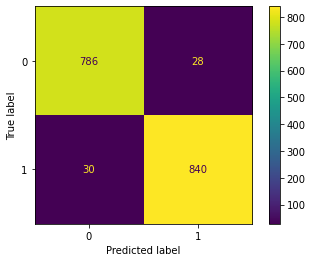

In [39]:
plot_confusion_matrix(grid, X_test, y_test); # pass in grid and X and y test data to form confusion matrix values

In [40]:
preds = grid.predict(X_test) # use grid to predict testing data
print(classification_report(y_test, preds)) # Calculate the specificity

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       814
           1       0.97      0.97      0.97       870

    accuracy                           0.97      1684
   macro avg       0.97      0.97      0.97      1684
weighted avg       0.97      0.97      0.97      1684



## Classification Inference:

- Recall: Out of all positives 97% of the data was predicted accurately as a peaceful protest.
- Precision: Out of all the positives which were predicted to be correct 97% were peaceful protest and 96% were not peaceful.

_______________
# Model 5 Random Forest with Count Vectorizer

In [41]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('rtc', RandomForestClassifier(n_jobs=4)) 
])
pipe_params = {
    'cv__stop_words': ['english'],
    "cv__max_features": [2000, 3000],
    'cv__min_df' : [1,2],
    'cv__max_df' : [.9,.95],
    'cv__ngram_range': [(1,1),(1,2)],
    
    "rtc__n_estimators": [50, 100, 150, 200],
    "rtc__max_depth": [2, 3, 4, 5, 10]
    

}

In [42]:
import time 

t0 = time.time() # instantiating time start
# Instantiate GridSearchCV.
grid = GridSearchCV(pipe, # optimize pipline
                  pipe_params, # search pipline params
                  cv=5, # 5-fold cross-validation for optimum value
                verbose=1) 
grid.fit(X_train,y_train) # fit our training data
print(int(round(t0 - time.time()))) # end time stamp

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed: 11.0min finished


-662


In [43]:
# Evaluate which params gave us our best score
grid.best_params_

{'cv__max_df': 0.95,
 'cv__max_features': 2000,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': 'english',
 'rtc__max_depth': 10,
 'rtc__n_estimators': 200}

In [44]:
grid.best_score_ # evalulate best score

0.9453690591611089

In [45]:
print(f'Training score: {grid.score(X_train,y_train)}')
print(f'Testing score: {grid.score(X_test,y_test)}')

Training score: 0.9568487727632621
Testing score: 0.9495249406175772


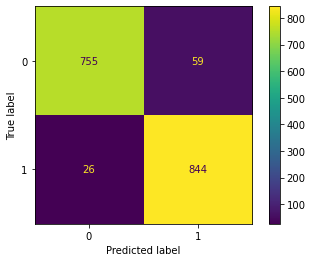

In [46]:
plot_confusion_matrix(grid, X_test, y_test);# pass in grid and X and y test data to form confusion matrix values

In [47]:
preds = grid.predict(X_test) # use grid to predict testing data
print(classification_report(y_test, preds)) # Calculate the specificity

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       814
           1       0.93      0.97      0.95       870

    accuracy                           0.95      1684
   macro avg       0.95      0.95      0.95      1684
weighted avg       0.95      0.95      0.95      1684



## Classification Inference:

- Recall: Out of all positives 98% of the data was predicted accurately to a peaceful protest.
- Precision: Out of all the positives which were predicted to be correct, 94% were peaceful protest and 97% were not peaceful.

_______________
# Model 6 Random Forest with TF-ID Vectorizer

In [48]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rtc', RandomForestClassifier(n_jobs=4)) 
])
pipe_params = {
    'tf__stop_words': ['english'],
    "tf__max_features": [2000, 3000],
    'tf__min_df' : [1,2],
    'tf__max_df' : [.9,.95],
    'tf__ngram_range': [(1,1),(1,2)],
    
    "rtc__n_estimators": [100, 150, 200],
    "rtc__max_depth": [2, 3, 4, 5, 10]
    
}

In [49]:
t1 = time.time() # instantiating time start
# Instantiate GridSearchCV.
grid = GridSearchCV(pipe, # optimize pipline
                  pipe_params, # search pipline params
                  cv=5, # 5-fold cross-validation for optimum value
                verbose=1) 
grid.fit(X_train,y_train) # fit our training data
print(int(round(t1 - time.time()))) # end time stamp

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 10.1min finished


-605


In [50]:
# Evaluate which params gave us our best score
grid.best_params_

{'rtc__max_depth': 10,
 'rtc__n_estimators': 100,
 'tf__max_df': 0.9,
 'tf__max_features': 3000,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': 'english'}

In [51]:
grid.best_score_ # evalulate best score

0.9305240375669614

In [52]:
print(f'Training score: {grid.score(X_train,y_train)}')
print(f'Testing score: {grid.score(X_test,y_test)}')

Training score: 0.9469517022961204
Testing score: 0.9263657957244655


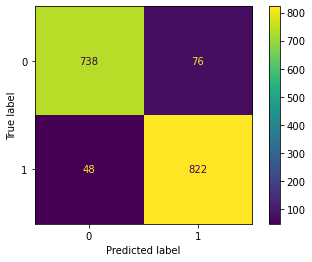

In [53]:
plot_confusion_matrix(grid, X_test, y_test)# pass in grid and X and y test data to form confusion matrix values

In [54]:
preds = grid.predict(X_test) # use grid to predict testing data
print(classification_report(y_test, preds)) # Calculate the specificity

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       814
           1       0.92      0.94      0.93       870

    accuracy                           0.93      1684
   macro avg       0.93      0.93      0.93      1684
weighted avg       0.93      0.93      0.93      1684



## Classification Inference:

- Recall: Out of all positives, 94% of protest was predicted accurately to having a peaceful outcome.
- Precision: Out of all the positives, which were predicted to be correct, 92% were peaceful protest and 93% were not peaceful.

_______________
# Model 7 SVM with Count Vectorizer

In [55]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('svc', SVC(degree=2))
])
pipe_params = {
    # cv parameters
    'cv__stop_words': [stopword],
    "cv__max_features": [2000, 3000],
    'cv__min_df' : [1,2],
    'cv__max_df' : [.9,.95],
    'cv__ngram_range': [(1,1),(1,2)],
    # svm parameters
    'svc__C': [.1,.15,.2,.25,.3],
    'svc__kernel': ['linear', 'rbf', 'polyn','sigmoid']
    
}

In [56]:
# Instantiate GridSearchCV.
grid = GridSearchCV(pipe, # optimize pipline
                  pipe_params, # search pipline params
                  cv=3, # 3-fold cross-validation for optimum value
                n_jobs=4) 
grid.fit(X_train,y_train) # fit our training data

/Users/aida/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('svc', SVC(degree=2))]),
             n_jobs=4,
             param_grid={'cv__max_df': [0.9, 0.95],
                         'cv__max_features': [2000, 3000], 'cv__min_df': [1, 2],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]],
           

In [57]:
# Evaluate which params gave us our best score
grid.best_params_

{'cv__max_df': 0.9,
 'cv__max_features': 3000,
 'cv__min_df': 2,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
 

In [58]:
grid.best_score_ # evalulate best score

0.9645684877276327

In [59]:
print(f'Training score: {grid.score(X_train,y_train)}')
print(f'Testing score: {grid.score(X_test,y_test)}')

Training score: 0.995249406175772
Testing score: 0.9673396674584323


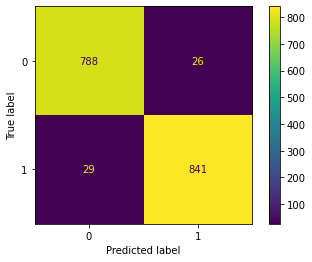

In [60]:
plot_confusion_matrix(grid, X_test, y_test);# pass in grid and X and y test data to form confusion matrix values

In [61]:
preds = grid.predict(X_test) # use grid to predict testing data
print(classification_report(y_test, preds)) # Calculate the specificity

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       814
           1       0.97      0.97      0.97       870

    accuracy                           0.97      1684
   macro avg       0.97      0.97      0.97      1684
weighted avg       0.97      0.97      0.97      1684



## Classification Inference:

- Recall: Out of all positives, 97% of protest was predicted accurately to having a peaceful outcome.
- Precision: Out of all the positives, which were predicted to be correct, 97% were peaceful protest and 96% were not peaceful.

_______________
# Model 8 SVM with TF-ID Vectorizer

In [62]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('svc', SVC(degree=2)) 
])
pipe_params = {
    # tfid parameters
    'tf__stop_words': [stopword],
    "tf__max_features": [2000, 3000],
    'tf__min_df' : [1,2],
    'tf__max_df' : [.9,.95],
    'tf__ngram_range': [(1,1),(1,2)],
    
    # svm parameters
    'svc__C': [.1,.15,.2,.25,.3],
    'svc__kernel': ['linear', 'rbf', 'polyn','sigmoid']
    
}

In [63]:
import time
t1 = time.time() # instantiating time start
# Instantiate GridSearchCV.
grid = GridSearchCV(pipe, # optimize pipline
                  pipe_params, # search pipline params
                  cv=3, # 5-fold cross-validation for optimum value
                n_jobs=4) 
grid.fit(X_train,y_train) # fit our training data
print(int(round(t1 - time.time()))) # end time stamp

-706


In [64]:
# Evaluate which params gave us our best score
grid.best_params_

{'svc__C': 0.3,
 'svc__kernel': 'linear',
 'tf__max_df': 0.9,
 'tf__max_features': 2000,
 'tf__min_df': 1,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',


In [65]:
grid.best_score_ # evalulate best score

0.9552652414885193

In [66]:
print(f'Training score: {grid.score(X_train,y_train)}')
print(f'Testing score: {grid.score(X_test,y_test)}')

Training score: 0.9750593824228029
Testing score: 0.9679334916864608


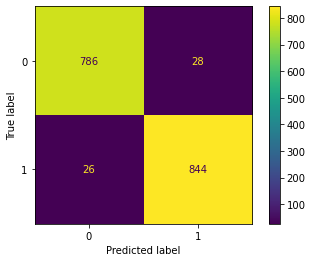

In [67]:
plot_confusion_matrix(grid, X_test, y_test)# pass in grid and X and y test data to form confusion matrix values

In [68]:
preds = grid.predict(X_test) # use grid to predict testing data
print(classification_report(y_test, preds)) # Calculate the specificity

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       814
           1       0.97      0.97      0.97       870

    accuracy                           0.97      1684
   macro avg       0.97      0.97      0.97      1684
weighted avg       0.97      0.97      0.97      1684



## Classification Inference:

- Recall: Out of all positives, 97% of protest was predicted accurately to having a peaceful outcome.
- Precision: Out of all the positives, which were predicted to be correct, 97% were peaceful protest and  also not peaceful.